## Step 1: Import packages and data

In [1]:
# %matplotlib notebook
# %matplotlib ipympl
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import itertools as it
from IPython.display import display
# from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm
from tslearn.metrics import dtw
# import sklearn_crfsuite
from time import time
import json

import warnings
warnings.filterwarnings('ignore')

desired_width=320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',20)
np.set_printoptions(linewidth=desired_width)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
Keypoints_1_7_normalized = pd.read_json('Keypoints_1_8_normalized_New.json', orient='records')

## Step 2: Feature Extraction

In [3]:
Keypoints_1_7_normalized.head()

,Gesture,Sub folder No.,Frame No.,Joint,X,Y,Depth
0,1,1,1,1,0.459640,0.291736,0.639216
1,1,1,1,2,0.424387,0.291780,0.639216
2,1,1,1,3,0.410519,0.395220,0.647059
3,1,1,1,4,0.407478,0.487731,0.639216
4,1,1,1,5,0.496337,0.291689,0.639216


In [4]:
pivot = Keypoints_1_7_normalized.pivot_table(index = ['Gesture', 'Sub folder No.', 'Frame No.'], columns = ['Joint'], values = ['X', 'Y', 'Depth'])
display(pivot.head())

Depth                                                                     X                      ...                                       Y                                                            
Joint                                    1         2         3         4         5         6         7         1         2         3  ...         5         6         7         1         2         3         4         5         6         7
Gesture Sub folder No. Frame No.                                                                                                      ...                                                                                                    
1       1              1          0.639216  0.639216  0.647059  0.639216  0.639216  0.639216  0.631373  0.459640  0.424387  0.410519  ...  0.496337  0.511610  0.510107  0.291736  0.291780  0.395220  0.487731  0.291689  0.395177  0.487628
                       2          0.639216  0.639216  0.658824  0.639216  0.647059  0.639216  0.631373  0.459640  0.424392  0.410554  ...  0.496333  0.511582  0.510085  0.291764  0.291817  0.395209  0.487708  0.291706  0.395219  0.487642
                       3          0.639216  0.639216  0.647059  0.639216  0.639216  0.639216  0.631373  0.459646  0.424398  0.410545  ...  0.496338  0.511598  0.510080  0.291766  0.291814  0.395226  0.487695  0.291717  0.395192  0.487635
                       4          0.639216  0.631373  0.658824  0.639216  0.639216  0.647059  0.631373  0.461075  0.425869  0.409115  ...  0.496353  0.511583  0.510093  0.291774  0.291824  0.395228  0.487729  0.291714  0.392556  0.487613
                       5          0.639216  0.647059  0.658824  0.647059  0.631373  0.639216  0.631373  0.461090  0.425876  0.408999  ...  0.496377  0.511604  0.510099  0.291786  0.291861  0.392478  0.479622  0.291694  0.397862  0.487660

[5 rows x 21 columns]

In [5]:
def joint_pair_distance(row, pairs):
    x = row['X']
    y = row['Y']
    z = row['Depth']
    
    result = np.empty(0)
    for pair in pairs:
        distance = np.sqrt((x[pair[0]] - x[pair[1]])**2 + (y[pair[0]] - y[pair[1]])**2 + (z[pair[0]] - z[pair[1]])**2)
        result = np.append(result, distance)
    return result

In [6]:
pairs = list(it.combinations(np.arange(1,8), 2))
joint_pair_distance_feature = pivot.apply(lambda x: joint_pair_distance(x, pairs), axis=1).rename('Feature')
joint_pair_distance_feature.to_frame().head()

Feature
Gesture Sub folder No. Frame No.                                                   
1       1              1          [0.035253169731879426, 0.11481821631348509, 0....
                       2          [0.03524793820627491, 0.11616723988329361, 0.2...
                       3          [0.03524802719075114, 0.11478907633664914, 0.2...
                       4          [0.03606838320137513, 0.11741830517451858, 0.2...
                       5          [0.0360774082742266, 0.11505174437926374, 0.20...

In [7]:
joint_pair_distance_feature_normalized = joint_pair_distance_feature.apply(lambda x: x/np.max(x)).rename('Feature_normalized')
joint_pair_distance_feature_normalized.to_frame().head()

Feature_normalized
Gesture Sub folder No. Frame No.                                                   
1       1              1          [0.16378520369288252, 0.5334421015070249, 0.94...
                       2          [0.16272209737118765, 0.5362860320796371, 0.93...
                       3          [0.1608931869132628, 0.5239663546185466, 0.936...
                       4          [0.1630229119332137, 0.5307106203497073, 0.936...
                       5          [0.16454604506690762, 0.5247413941644206, 0.92...

In [8]:
#joint_pair_distance_feature_normalized2 = joint_pair_distance_feature_normalized.apply(lambda x: x/joint_pair_distance_feature_normalized.iloc[0]).rename('Feature_normalized2')
#joint_pair_distance_feature_normalized2.to_frame().head()

## Step 3: Prepare Training and Testing Dataset

In [9]:
gesture_number = len(Keypoints_1_7_normalized['Gesture'].unique())

In [10]:
dataset = joint_pair_distance_feature_normalized.reset_index().pivot_table(index=['Gesture', 'Sub folder No.'], values=['Feature_normalized'], aggfunc=lambda x: np.vstack(x).tolist()).iloc[:,0]
dataset.to_frame().head()

Feature_normalized
Gesture Sub folder No.                                                   
1       1               [[0.16378520369288252, 0.5334421015070249, 0.9...
        2               [[0.17471872658208118, 0.5378476847798014, 0.9...
        3               [[0.18216633181606004, 0.5231743019007848, 0.9...
        4               [[0.1716376696151291, 0.5519438903924956, 0.94...
        5               [[0.167079341578526, 0.5377976506992708, 0.947...

### 80% - 20%

In [11]:
msk = np.concatenate([np.random.rand(len(dataset.loc[i])) < 0.8 for i in np.arange(1,gesture_number+1)])
train_data_8020 = dataset.iloc[msk]
test_data_8020 = dataset.iloc[~msk]
print('80%-20% Train dataset\'s recording number', len(train_data_8020))
print('80%-20% Test dataset\'s recording number', len(test_data_8020))

test_label_8020 = test_data_8020.reset_index(0).iloc[:,0].values
print('80%-20% Test label:', test_label_8020)

80%-20% Train dataset's recording number 118
80%-20% Test dataset's recording number 26
80%-20% Test label: [1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]


### Jack-Knife

In [12]:
train_data_jackknife = pd.concat([dataset[[dataset.index.values[i][0] == j for i in range(len(dataset))]].iloc[pd.np.r_[0:9, 12:18]] for j in range(1,gesture_number+1)])
test_data_jackknife = pd.concat([dataset[[dataset.index.values[i][0] == j for i in range(len(dataset))]].iloc[9:12] for j in range(1,gesture_number+1)])
print('Jack-Knife Train dataset\'s recording number', len(train_data_jackknife))
print('Jack-Knife Test dataset\'s recording number', len(test_data_jackknife))

test_label_jackknife = test_data_jackknife.reset_index(0).iloc[:,0].values
print('Jack-Knife Test label:', test_label_jackknife)

Jack-Knife Train dataset's recording number 120
Jack-Knife Test dataset's recording number 24
Jack-Knife Test label: [1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]


## Step 4: Gaussian HMM

### 80% - 20%

In [13]:
hmm_train_data_8020 = [np.vstack(train_data_8020.loc[i].values) for i in range(1, gesture_number+1)]
[print('80%%-20%% Gesture %d Train data shape: %s' % (i+1, hmm_train_data_8020[i].shape)) for i in range(gesture_number)]
print()
hmm_train_lengths_8020 = [train_data_8020.loc[i].apply(len).values for i in range(1, gesture_number+1)]
[print('80%%-20%% Gesture %d Train sequence lengths: %s' % (i+1, hmm_train_lengths_8020[i])) for i in range(gesture_number)]
print()

80%-20% Gesture 1 Train data shape: (982, 21)
80%-20% Gesture 2 Train data shape: (696, 21)
80%-20% Gesture 3 Train data shape: (780, 21)
80%-20% Gesture 4 Train data shape: (617, 21)
80%-20% Gesture 5 Train data shape: (779, 21)
80%-20% Gesture 6 Train data shape: (676, 21)
80%-20% Gesture 7 Train data shape: (735, 21)
80%-20% Gesture 8 Train data shape: (632, 21)

80%-20% Gesture 1 Train sequence lengths: [61 62 69 49 54 55 63 62 61 78 73 61 62 56 60 56]
80%-20% Gesture 2 Train sequence lengths: [63 49 68 36 36 38 38 37 36 48 57 57 50 42 41]
80%-20% Gesture 3 Train sequence lengths: [61 60 63 38 38 39 35 39 48 50 45 64 55 59 45 41]
80%-20% Gesture 4 Train sequence lengths: [39 48 43 39 40 40 42 39 45 40 54 61 43 44]
80%-20% Gesture 5 Train sequence lengths: [47 52 50 52 52 51 53 60 63 61 59 63 59 57]
80%-20% Gesture 6 Train sequence lengths: [42 43 43 45 46 44 47 42 44 61 56 64 51 48]
80%-20% Gesture 7 Train sequence lengths: [47 48 50 47 45 42 59 60 44 41 43 51 52 51 55]
80%-20% Ges

#### Diag covariance

In [14]:
print('80%-20%, Diagonal covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='diag').fit(hmm_train_data_8020[i], lengths=hmm_train_lengths_8020[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_8020.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_8020)
    
    accuracy.append(np.sum(test_predict == test_label_8020) / len(test_label_8020))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_8020, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

80%-20%, Diagonal covariance

HMM state = 1,	Accuracy = 1.000,	Run time = 0.003
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 3,	Accuracy = 1.000,	Run time = 0.003
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 5,	Accuracy = 0.962,	Run time = 0.003
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 6 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 7,	Accuracy = 1.000,	Run time = 0.004
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 9,	Accuracy = 0.962,	Run time = 0.004
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 6 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 11,	Accuracy = 1.000,	Run time = 0.005
Label:		[1 1 2 2 2 3 3 4

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


HMM state = 17,	Accuracy = 0.846,	Run time = 0.006
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 7 5 3]



Some rows of transmat_ have zero sum because no transition from the state was ever observed.


HMM state = 19,	Accuracy = 0.846,	Run time = 0.007
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 7 5 3]

HMM state = 21,	Accuracy = 1.000,	Run time = 0.009
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]



Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


HMM state = 23,	Accuracy = 0.769,	Run time = 0.008
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 7 7 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 7 5 6]

HMM state = 25,	Accuracy = 1.000,	Run time = 0.012
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]



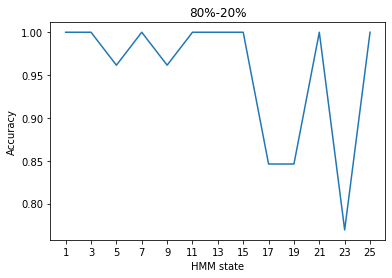

In [15]:
fig1 = plt.figure()
plt.title('80%-20%')
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.show()

In [16]:
print('80%-20%, Diagonal covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_8020, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_8020, best_test_predict))

80%-20%, Diagonal covariance

Best accuracy occurs when:
HMM state = 1,		Best accuracy = 1.000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Confusion Matrix:
 [[2 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 4]]


#### Full covariance

In [17]:
print('80%-20%, Full covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='full').fit(hmm_train_data_8020[i], lengths=hmm_train_lengths_8020[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_8020.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_8020)
    
    accuracy.append(np.sum(test_predict == test_label_8020) / len(test_label_8020))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_8020, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

80%-20%, Full covariance

HMM state = 1,	Accuracy = 1.000,	Run time = 0.004
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 3,	Accuracy = 1.000,	Run time = 0.006
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 5,	Accuracy = 0.962,	Run time = 0.009
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 1 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 7,	Accuracy = 0.962,	Run time = 0.012
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 7 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 9,	Accuracy = 1.000,	Run time = 0.013
Label:		[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]
Prediction:	[1 1 2 2 2 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 8 8 8 8]

HMM state = 11,	Accuracy = 0.962,	Run time = 0.018
Label:		[1 1 2 2 2 3 3 4 4 4

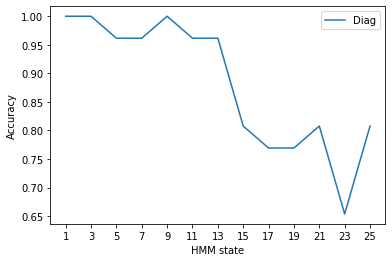

In [18]:
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.legend(['Diag', 'Full'])
plt.show()

In [19]:
print('80%-20%, Full covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_8020, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_8020, best_test_predict))

80%-20%, Full covariance

Best accuracy occurs when:
HMM state = 1,		Best accuracy = 1.000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Confusion Matrix:
 [[2 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 4]]


### Jack-Knife

In [20]:
hmm_train_data_jackknife = [np.vstack(train_data_jackknife.loc[i].values) for i in range(1, gesture_number+1)]
[print('Jack-Knife Gesture %d Train data shape: %s' % (i+1, hmm_train_data_jackknife[i].shape)) for i in range(gesture_number)]
print()
hmm_train_lengths_jackknife = [train_data_jackknife.loc[i].apply(len).values for i in range(1, gesture_number+1)]
[print('Jack-Knife Gesture %d Train sequence lengths: %s' % (i+1, hmm_train_lengths_jackknife[i])) for i in range(gesture_number)]
print()

Jack-Knife Gesture 1 Train data shape: (892, 21)
Jack-Knife Gesture 2 Train data shape: (692, 21)
Jack-Knife Gesture 3 Train data shape: (721, 21)
Jack-Knife Gesture 4 Train data shape: (697, 21)
Jack-Knife Gesture 5 Train data shape: (825, 21)
Jack-Knife Gesture 6 Train data shape: (726, 21)
Jack-Knife Gesture 7 Train data shape: (769, 21)
Jack-Knife Gesture 8 Train data shape: (681, 21)

Jack-Knife Gesture 1 Train sequence lengths: [61 62 69 49 54 55 63 62 61 61 61 62 56 60 56]
Jack-Knife Gesture 2 Train sequence lengths: [63 49 68 36 36 38 38 37 36 57 59 50 42 42 41]
Jack-Knife Gesture 3 Train sequence lengths: [61 60 63 38 38 39 35 36 39 64 55 59 45 41 48]
Jack-Knife Gesture 4 Train sequence lengths: [46 39 48 43 39 40 40 42 39 54 61 63 56 43 44]
Jack-Knife Gesture 5 Train sequence lengths: [47 52 50 54 52 55 52 51 53 59 63 63 59 57 58]
Jack-Knife Gesture 6 Train sequence lengths: [42 43 43 45 46 44 43 47 42 61 56 64 51 51 48]
Jack-Knife Gesture 7 Train sequence lengths: [47 48 50 

#### Diag covariance

In [21]:
print('Jack-Knife, Diagonal covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='diag').fit(hmm_train_data_jackknife[i], lengths=hmm_train_lengths_jackknife[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_jackknife.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_jackknife)
    
    accuracy.append(np.sum(test_predict == test_label_jackknife) / len(test_label_jackknife))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_jackknife, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

Jack-Knife, Diagonal covariance

HMM state = 1,	Accuracy = 1.000,	Run time = 0.003
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 3,	Accuracy = 1.000,	Run time = 0.003
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 5,	Accuracy = 1.000,	Run time = 0.004
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 7,	Accuracy = 1.000,	Run time = 0.004
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 9,	Accuracy = 1.000,	Run time = 0.004
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 11,	Accuracy = 0.917,	Run time = 0.005
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Pre

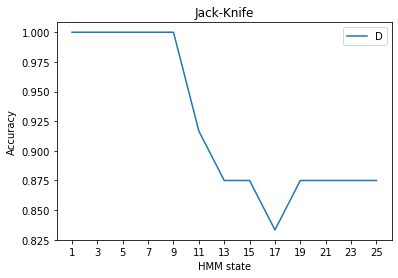

In [22]:
fig2 = plt.figure()
plt.title('Jack-Knife')
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.legend('Diag')
plt.show()

In [23]:
print('Jack-Knife, Diagonal covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_jackknife, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_jackknife, best_test_predict))

Jack-Knife, Diagonal covariance

Best accuracy occurs when:
HMM state = 1,		Best accuracy = 1.000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

Confusion Matrix:
 [[3 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0]
 [0 0 0 3 0 0 0 0]
 [0 0 0 0 3 0 0 0]
 [0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 3]]


#### Full covariance

In [24]:
print('Jack-Knife, Full covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='full').fit(hmm_train_data_jackknife[i], lengths=hmm_train_lengths_jackknife[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_jackknife.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_jackknife)
    
    accuracy.append(np.sum(test_predict == test_label_jackknife) / len(test_label_jackknife))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_jackknife, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

Jack-Knife, Full covariance

HMM state = 1,	Accuracy = 1.000,	Run time = 0.005
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 3,	Accuracy = 1.000,	Run time = 0.007
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 5,	Accuracy = 0.917,	Run time = 0.009
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 7 7 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 7,	Accuracy = 1.000,	Run time = 0.011
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 9,	Accuracy = 0.958,	Run time = 0.013
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Prediction:	[1 1 1 2 2 2 3 3 3 4 5 4 5 5 5 6 6 6 7 7 7 8 8 8]

HMM state = 11,	Accuracy = 0.792,	Run time = 0.016
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Predict

ValueError: x and y must have same first dimension, but have shapes (13,) and (14,)

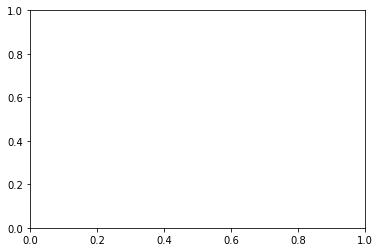

In [28]:
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.legend(['Diag', 'Full'])
plt.show()

In [ ]:
print('Jack-Knife, Full covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_jackknife, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_jackknife, best_test_predict))

### Get trained HMM parameters

In [52]:
train_data_jackknife = pd.concat([dataset[[dataset.index.values[i][0] == j for i in range(len(dataset))]] for j in range(1,gesture_number+1)])
print('Jack-Knife Train dataset\'s recording number', len(train_data_jackknife), '\n')

hmm_train_data_jackknife = [np.vstack(train_data_jackknife.loc[i].values) for i in range(1, gesture_number+1)]
[print('Jack-Knife Gesture %d Train data shape: %s' % (i+1, hmm_train_data_jackknife[i].shape)) for i in range(gesture_number)]
print()
hmm_train_lengths_jackknife = [train_data_jackknife.loc[i].apply(len).values for i in range(1, gesture_number+1)]
[print('Jack-Knife Gesture %d Train sequence lengths: %s' % (i+1, hmm_train_lengths_jackknife[i])) for i in range(gesture_number)]
print()

Jack-Knife Train dataset's recording number 144 

Jack-Knife Gesture 1 Train data shape: (1115, 21)
Jack-Knife Gesture 2 Train data shape: (852, 21)
Jack-Knife Gesture 3 Train data shape: (864, 21)
Jack-Knife Gesture 4 Train data shape: (829, 21)
Jack-Knife Gesture 5 Train data shape: (1009, 21)
Jack-Knife Gesture 6 Train data shape: (868, 21)
Jack-Knife Gesture 7 Train data shape: (897, 21)
Jack-Knife Gesture 8 Train data shape: (817, 21)

Jack-Knife Gesture 1 Train sequence lengths: [61 62 69 49 54 55 63 62 61 72 78 73 61 61 62 56 60 56]
Jack-Knife Gesture 2 Train sequence lengths: [63 49 68 36 36 38 38 37 36 48 55 57 57 59 50 42 42 41]
Jack-Knife Gesture 3 Train sequence lengths: [61 60 63 38 38 39 35 36 39 48 50 45 64 55 59 45 41 48]
Jack-Knife Gesture 4 Train sequence lengths: [46 39 48 43 39 40 40 42 39 45 40 47 54 61 63 56 43 44]
Jack-Knife Gesture 5 Train sequence lengths: [47 52 50 54 52 55 52 51 53 60 63 61 59 63 63 59 57 58]
Jack-Knife Gesture 6 Train sequence lengths: [42 4

In [53]:
state = 1

hmm_model = []
# Train a HMM model using time sequences of training, train one HMM model for each gesture
for i in range(gesture_number):
    hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='full').fit(hmm_train_data_jackknife[i], lengths=hmm_train_lengths_jackknife[i]))

    
trained_param = {}
trained_param['startprob'] = []
trained_param['transmat'] = []
trained_param['means'] = []
trained_param['covars'] = []

for i in range(gesture_number):
    trained_param['startprob'].append(hmm_model[i].startprob_.tolist())
    trained_param['transmat'].append(hmm_model[i].transmat_.tolist())
    trained_param['means'].append(hmm_model[i].means_.tolist())
    trained_param['covars'].append(hmm_model[i].covars_.tolist())

    
with open('hmm_jackknife_full_trained_param.json', 'w') as json_file:
    json.dump(trained_param, json_file)

## Step 5: CRF

In [ ]:
def crf_features(record):
    result = []
    for frame_feature in record:
        result.append(dict(zip(np.arange(1,22).astype('str'), frame_feature)))
    return result

### 80% - 20%

In [ ]:
crf_train_data_8020 = train_data_8020.apply(crf_features)
crf_test_data_8020 = test_data_8020.apply(crf_features)

In [ ]:
train_label_8020 = train_data_8020.reset_index(0).iloc[:,0].values
crf_train_label_8020 = [np.repeat(train_label_8020[i], len(train_data_8020.iloc[i])).astype('str').tolist() for i in range(len(train_label_8020))]

test_label_8020 = test_data_8020.reset_index(0).iloc[:,0].values
crf_test_label_8020 = [np.repeat(test_label_8020[i], len(test_data_8020.iloc[i])).astype('str').tolist() for i in range(len(test_label_8020))]

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
#     c1=0.1,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
)
crf.fit(crf_train_data_8020, crf_train_label_8020)

In [ ]:
start_time = time()
crf_test_predict = crf.predict(crf_test_data_8020)
# labels = np.arange(1,8).astype('str').tolist()
# accuracy = metrics.flat_f1_score(crf_test_label, crf_test_predict,
#                       average='weighted', labels=labels)
test_predict = [int(max(set(x), key=x.count)) for x in crf_test_predict]
end_time = time()
run_time = (end_time - start_time) / len(test_label_8020)

accuracy = np.sum(test_predict == test_label_8020) / len(test_label_8020)

In [ ]:
print('80%-20%\n')
print('Best accuracy = %.3f\tRun time = %.3f\n' % (accuracy, run_time))
print('Classification Report:\n', classification_report(test_label_8020, test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_8020, test_predict))

### Jack-Knife

In [ ]:
crf_train_data_jackknife = train_data_jackknife.apply(crf_features)
crf_test_data_jackknife = test_data_jackknife.apply(crf_features)

In [ ]:
train_label_jackknife = train_data_jackknife.reset_index(0).iloc[:,0].values
crf_train_label_jackknife = [np.repeat(train_label_jackknife[i], len(train_data_jackknife.iloc[i])).astype('str').tolist() for i in range(len(train_label_jackknife))]

test_label_jackknife = test_data_jackknife.reset_index(0).iloc[:,0].values
crf_test_label_jackknife = [np.repeat(test_label_jackknife[i], len(test_data_jackknife.iloc[i])).astype('str').tolist() for i in range(len(test_label_jackknife))]

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
#     c1=0.1,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
)
crf.fit(crf_train_data_jackknife, crf_train_label_jackknife)

In [ ]:
start_time = time()
crf_test_predict = crf.predict(crf_test_data_jackknife)
# labels = np.arange(1,8).astype('str').tolist()
# accuracy = metrics.flat_f1_score(crf_test_label, crf_test_predict,
#                       average='weighted', labels=labels)
test_predict = [int(max(set(x), key=x.count)) for x in crf_test_predict]
end_time = time()
run_time = (end_time - start_time) / len(test_label_jackknife)

accuracy = np.sum(test_predict == test_label_jackknife) / len(test_label_jackknife)

In [ ]:
print('Jack-Knife\n')
print('Best accuracy = %.3f\tRun time = %.3f\n' % (accuracy, run_time))
print('Classification Report:\n', classification_report(test_label_jackknife, test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_jackknife, test_predict))

## Step 6: DTW

In [34]:
dtw_train_data = dataset.loc[:,1]
dtw_test_data = dataset.loc[:,2:]
display(dtw_train_data)
display(dtw_test_data.head())

Gesture
1    [[0.16378520369288252, 0.5334421015070249, 0.9...
2    [[0.16174080402277669, 0.5380593474150027, 0.9...
3    [[0.16328926488583456, 0.5355900599443473, 0.9...
4    [[0.16046884294278801, 0.5577949378282874, 0.9...
5    [[0.16468131885122744, 0.542795781008123, 0.93...
6    [[0.16462263725702592, 0.5389471104001583, 0.9...
7    [[0.1812600364399212, 0.5495971931080154, 0.94...
8    [[0.16733951702542296, 0.545824450648114, 0.94...
Name: Feature_normalized, dtype: object

Gesture  Sub folder No.
1        2                 [[0.17471872658208118, 0.5378476847798014, 0.9...
         3                 [[0.18216633181606004, 0.5231743019007848, 0.9...
         4                 [[0.1716376696151291, 0.5519438903924956, 0.94...
         5                 [[0.167079341578526, 0.5377976506992708, 0.947...
         6                 [[0.15763667447305574, 0.5235416460121718, 0.9...
Name: Feature_normalized, dtype: object

In [35]:
dtw_train_data.rename_axis(2).get_values
import csv
dtw_csv = []
for i in range(8):
    dtw_csv.append(dtw_train_data.iloc[i])
with open('dtw_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(dtw_csv)

In [36]:
dtw_test_label = dtw_test_data.reset_index().iloc[:,0].values

In [ ]:
dtw_test_pred = np.empty(len(test_label_dtw))
start_time = time()
for i in range(len(dtw_test_label)):
    dist = np.empty(gesture_number)
    for j in range(gesture_number):
        dist[j] = dtw(dtw_train_data.iloc[j], dtw_test_data.iloc[i])
    dtw_test_pred[i] = np.argmin(dist) + 1
end_time = time()

run_time = (end_time - start_time) / len(dtw_test_label)
accuracy = np.sum(dtw_test_pred == dtw_test_label) / len(dtw_test_label)

In [ ]:
print('Best accuracy = %.3f\tRun time = %.3f\n' % (accuracy, run_time))
print('Classification Report:\n', classification_report(dtw_test_label, dtw_test_pred))
print('Confusion Matrix:\n', confusion_matrix(dtw_test_label, dtw_test_pred))